# Sherlock Holmes: A game of statistics
Imagine the following scene in a Hollywood blockbuster movie version of Sherlock Holmes:

Sherlock, hears just three pieces of information before letting Doctor Watson know that the plot has already been foiled.
"They are in Tulsa, Oklahoma."

    "But how could you ever deduce that? We don't even know where they departed from."
    
"If a tree falls in a forest and no one is around to hear it, does it make a sound?"

    "Sherlock, less of the epistimology please, now is not the time!"
    
"The answer is perfectly logical if the forest is a random one." 

At this Watson's deep stare unlocks Sherlock's ever more self satisfactory explaination.
"The napkin gave away the air carrier and from the times the messages were sent, we know when they departed and how long they were in the air. Just under an hour on American Airlines, I'm over ninety nine percent sure that they are in Tulsa."

After a short sharp outward breath, Watson responds.
    "Sherlock, I'm not quite sure why the epistimolgy of random forests is relevant, but shouldn't we be leaving now?"

## Data
Illogical as it may sound to predict where a flight is going simply from the airline and flight times, we can do so without knowing how airline schedules work. Given a sample of airline data, several techniques lend themselves to classifying aircraft destination (a categorical label) based on seemingly abstracted predictors (both categorical and quantiative).
First, let's download the airline data, keep only the complete cases, and have a look at the result:

In [5]:
air <- read.csv("https://github.com/rbnsnsd2/quantitative_stats/raw/master/airline_dec_2008_50k.csv", header=TRUE)
air <- air[complete.cases(air),]
head(air)

,X,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,⋯,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
17623,17623,2008,12,1,1,7,10,659,629,DL,⋯,28,15,0,,0,0,0,30,0,0
18123,18123,2008,12,20,6,3,2310,58,5,AA,⋯,5,15,0,,0,8,0,0,0,45
18601,18601,2008,12,8,1,3,2325,51,20,AA,⋯,6,9,0,,0,31,0,0,0,0
18606,18606,2008,12,1,1,15,2115,329,5,MQ,⋯,3,46,0,,0,38,0,24,0,142
18607,18607,2008,12,1,1,16,20,616,553,NW,⋯,13,14,0,,0,0,0,23,0,0
18611,18611,2008,12,1,1,30,25,611,556,NW,⋯,5,12,0,,0,0,0,15,0,0


For the sake of this example, we can reduce the number of possible locations down to five. For some classifiers there is an upper limit to the number of available labels, but in this case we simply want to be able to render the results cleanly.

In [6]:
suppressWarnings(library("dplyr"))
destinations <- unique(air$Dest)
air <- filter(air, Dest %in% destinations[1:5])
air$Dest <- factor(air$Dest) #Reduce the available labels to those actually present

Before running the models, we need to pull the necessary libraries. 

In [7]:
#install.packages("rpart.plot", dependencies=TRUE)
#install.packages("randomForest", dependencies=TRUE)
library(randomForest)
library(e1071) #SVM and naive Bayes
library(rpart) #Trees & partition
library(rpart.plot) #This allows us to plot the trees in a more interpretable format
set.seed(42) #Create a reproducable "random."

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine



## Support vector machines
SVMs consist of a set of binary linear classifiers which identify if a given sample is from a single category or not. Within SVMs each sample is considered as a vector in a vector-space. A hyperplane of lower dimension is drawn between the categories maximizing the distance between the categorical vectors and the plane (maximum margin hyperplane). With this approach the SVM is linear, but can be extended by first transforming the data in a manner that satisfies the kernel function. The non-linear model version is known as the kernel trick.
The application of SVM and the resulting confusion matrix and accuracy are as follows:

In [8]:
air.svm <- svm(Dest ~ CRSElapsedTime + CRSDepTime + UniqueCarrier, data=air)
svm.pred=predict(air.svm, air)
table(svm.pred, air$Dest) #Confusion matrix
round(sum(svm.pred == air$Dest)/length(svm.pred), 3)

        
svm.pred AUS JFK MSP PHL TUL
     AUS   0   0   0   0   0
     JFK   2 130   7   7   7
     MSP   0   0  89   1   0
     PHL   4   1   1  74   3
     TUL   4   0   2   0  14

[1] 0.887

## Naive Bayes
The naive Bayes classifier assumes that all measures are independent of one another and thus naive. The classification label is given to that which is the most likely from the product of the probabilities of each individual measure. 
For as simple as this model appears, it performs well in many applications. The computational load to train these models is also fairly low.
The application of naive Bayes and the resulting confusion matrix and accuracy are as follows:

In [9]:
air.nb <- naiveBayes(Dest ~ CRSElapsedTime + CRSDepTime + UniqueCarrier, data=air)
nb.pred=predict(air.nb, air)
table(nb.pred, air$Dest) #Confusion matrix
round(sum(nb.pred == air$Dest)/length(nb.pred), 3)

       
nb.pred AUS JFK MSP PHL TUL
    AUS   2   1   0   0   0
    JFK   0 116   0   8   0
    MSP   0   0  94   3   0
    PHL   4  14   2  71   9
    TUL   4   0   3   0  15

[1] 0.861

## Decision trees
Recursive partitioning (rpart) (or decision trees) classify samples by measurement against a repeated series of criteria with a dichotomous outcome until the sample has been classified. The outcome has the benefits of being simple to interpret and performing well. However, care has to be taken with data overfitting and continuous variables.

The application of decision trees and the resulting confusion matrix and accuracy are as follows:

In [10]:
air.tr <- rpart(Dest ~ CRSElapsedTime + CRSDepTime + UniqueCarrier, data=air)
tr.pred=predict(air.tr, type="class")
table(tr.pred, air$Dest) #Confusion matrix
round(sum(tr.pred == air$Dest)/length(tr.pred), 3)

       
tr.pred AUS JFK MSP PHL TUL
    AUS   0   0   0   0   0
    JFK   0 124   3   6   2
    MSP   2   0  95   2   0
    PHL   4   7   1  74   2
    TUL   4   0   0   0  20

[1] 0.905

Here we can see that the decision tree performs very well when compared against the data that was used to fit it. To avoid overfitting, the tree may be "pruned" and the resulting model performance compared with a previously held out set.
In our particular case this has limited effect:

In [11]:
p.air.tr<- prune(air.tr, cp = air.tr$cptable[which.min(air.tr$cptable[,"xerror"]),"CP"])
p.tr.pred=predict(air.tr, type="class")
round(sum(p.tr.pred == air$Dest)/length(tr.pred), 3)

[1] 0.905

Where the decision tree excels is in how simply it can be understood graphically. Below, we can see the fractions separated by each decision, the percentage of the whole and the criteria for each decision branch.


AUS JFK MSP PHL TUL 
 10 131  99  82  24 

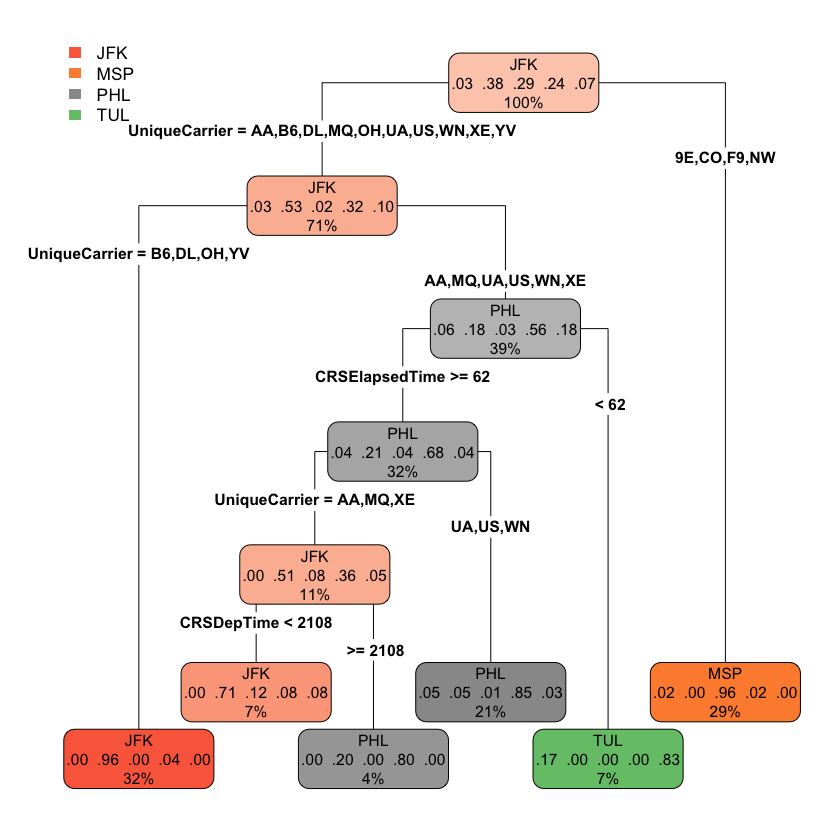

In [12]:
rpart.plot(p.air.tr, type=4)
table(air$Dest)

## Random forest
Random forests (a trademarked title) in essence, are a series of bootstrapped decision trees that are chosen to minimize unexplained variance. From the multitude of tree models created from the bootstrapped samples that form the model, each one is compared to determine the model outcome. Where the outcome is a continuous variable, the mean of the tree outcomes is taken. For catagorical labels, the majority vote of all trees is taken as the outcome. This approach overcomes the overfitting problem of the simple decision tree and generally performs better.
The application of the random forest and the resulting confusion matrix and accuracy are as follows:

In [13]:
air.rf <- randomForest(Dest ~ CRSElapsedTime + CRSDepTime + UniqueCarrier, data=air, importance=TRUE, proximity=TRUE)
rf.pred=predict(air.rf, air)
table(rf.pred, air$Dest) #Confusion matrix
round(sum(rf.pred == air$Dest)/length(rf.pred), 3)

       
rf.pred AUS JFK MSP PHL TUL
    AUS  10   0   0   0   0
    JFK   0 131   0   0   0
    MSP   0   0  99   1   0
    PHL   0   0   0  81   2
    TUL   0   0   0   0  22

[1] 0.991

As we can see from the result, it performs very well and better than the other approaches demonstrated. This is also true for a larger set of labels. We can repeat our experiment for 50 destinations as follows to equally impressive results:

In [15]:
air <- read.csv("https://github.com/rbnsnsd2/quantitative_stats/raw/master/airline_dec_2008_50k.csv", header=TRUE)
air <- air[complete.cases(air),]

destinations <- unique(air$Dest)
air <- filter(air, Dest %in% destinations[1:50])
air$Dest <- factor(air$Dest) #Reduce the available labels to those actually present

air.rf <- randomForest(Dest ~ CRSElapsedTime + CRSDepTime + UniqueCarrier, data=air, importance=TRUE, proximity=TRUE)
rf.pred=predict(air.rf, air)
#table(rf.pred, air$Dest) #Confusion matrix
round(sum(rf.pred == air$Dest)/length(rf.pred), 3)

[1] 0.927